# Librerias

In [131]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
import pathlib
from pathlib import Path  

In [132]:
from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

# DATASET DESDE DIRECTORIO 

In [133]:
directorio_dataset = ('../Datasets/CIFAR-10 dos clases')
imagenes_originales = ('../Datasets/CIFAR-10 dos clases/cat')
imagenes_corruptas = ('../Datasets/CIFAR-10 dos clases/cat_c_defocus_blur')

directorio_dataset = pathlib.Path(directorio_dataset)
imagenes_originales = pathlib.Path(imagenes_originales)
imagenes_corruptas = pathlib.Path(imagenes_corruptas)

total_dataset = len(list(directorio_dataset.glob('*/*.png')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_originales = len(list(imagenes_originales.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_corruptas = len(list(imagenes_corruptas.glob('*.png')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes originales: {total_originales}")
print(f"Total imagenes corruptas: {total_corruptas}")

Total imagenes dataset: 10000
Total imagenes originales: 5000
Total imagenes corruptas: 5000


In [134]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [135]:

import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.


In [136]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [137]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(10000, 32, 32, 3)


# CSG

c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


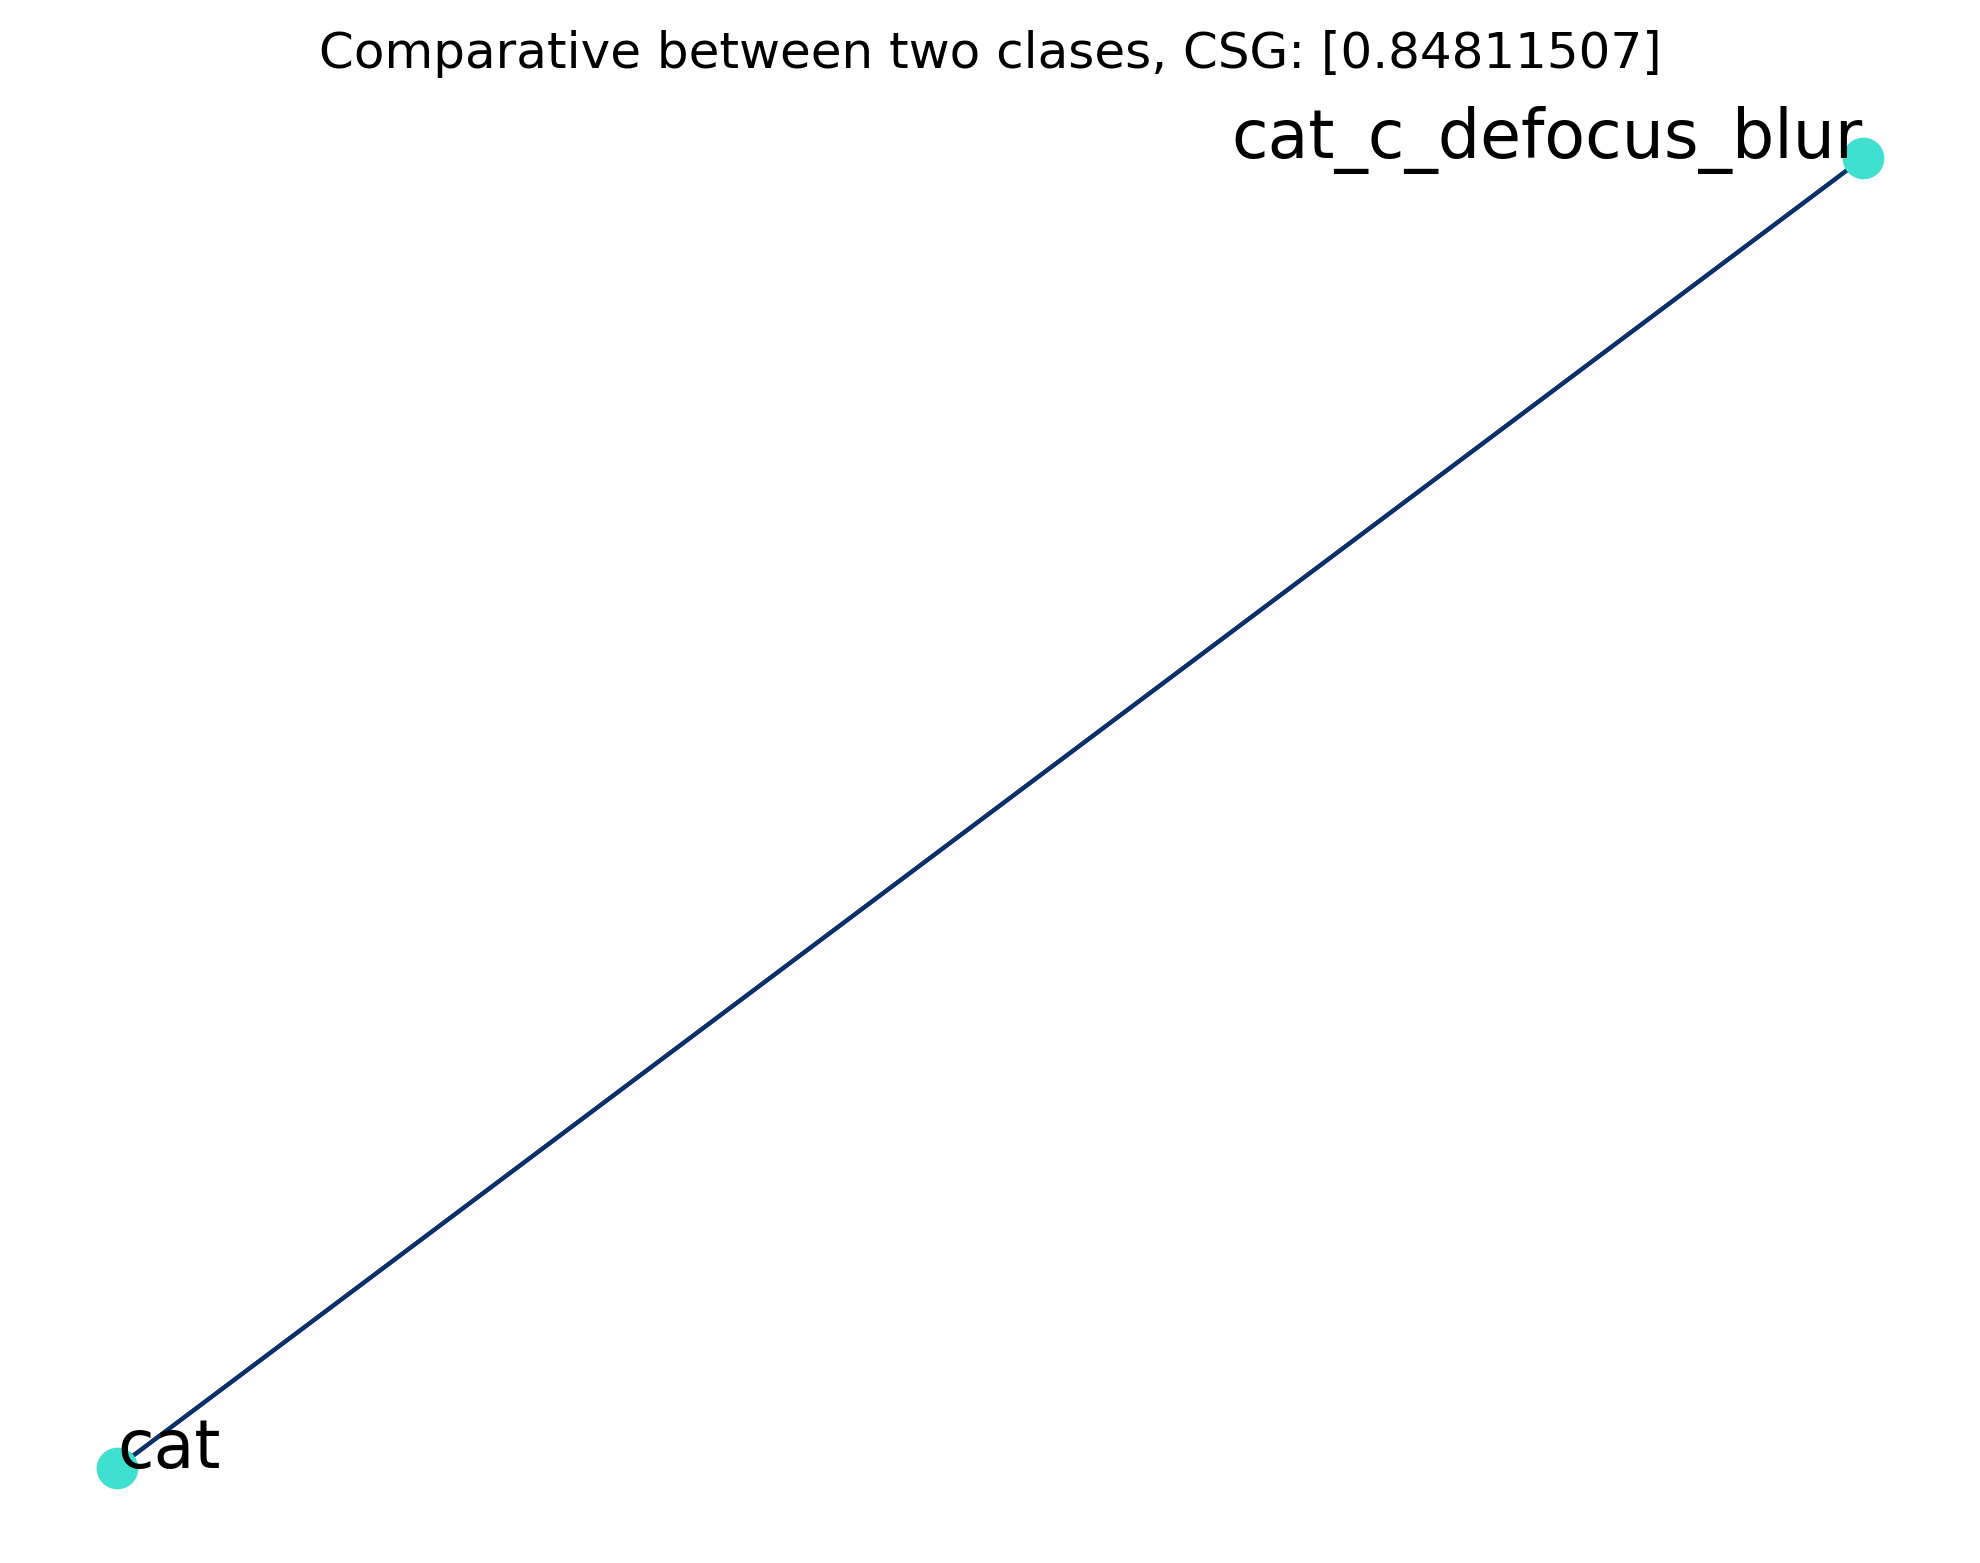

In [138]:
# CIFAR-10 Two classes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=5000, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

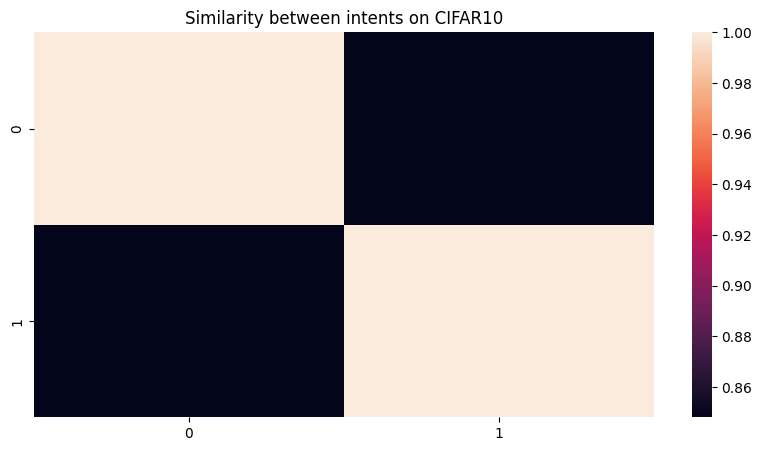

In [139]:
plt.figure(figsize=(10,5))
sns.heatmap(estimator.W)
plt.title("Similarity between intents on CIFAR10")
plt.show()

In [140]:

from scipy.stats import entropy
import pandas as pd

entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)
print("Class that is the most confused (highest entropy):", class_names[np.argmax(entropy_per_class)])


Class that is the most confused (highest entropy): cat


Comparar clases con la matriz W

In [141]:
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))[::-1]
pairs = [(i,j) for i,j in pairs if i != j]
print("Most similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:10]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))

Most similar pairs
                 Intent pair  Similarity
0  cat_c_defocus_blur <> cat    0.848115


Obtener los nombres de las imagenes

In [142]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a rutas completas de archivo  
filenames_dict = {i: str(f) for i, f in enumerate(directorio_dataset.glob('*/*.png'))} 

Comparar las muestras con la matriz W

In [143]:
# Muestras mas similares

def show_most_confused(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener las probabilidades de la clase objetivo
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]
    
    # Ordenar en orden descendente (De mas similar a menos similar) 
    closest_to_second = np.argsort(probabilities)[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    print(dataset_indices.shape)

    # Verificar que los índices estén dentro de los límites del dataset
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]
    
    for di in valid_indices:
        try:
            filename_route = filenames_dict[int(di)]  # Directorio en donde estan las imagenes 
            filename = Path(filename_route).name  # Extraer solo el nombre del archivo sin su ruta
            value = probabilities[closest_to_second[np.where(dataset_indices == di)[0][0]]]  
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
        except IndexError:
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)
# for class_name, indices in estimator.class_indices.items():
#     print(f"Clase: {class_names}, Número de muestras: {len(indices)}")

cat <> cat_c_defocus_blur
(10,)
	Nombre del archivo: domestic_cat_s_000565.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_s_000720.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_cat_s_001985.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: felis_catus_s_000972.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_s_001111.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: house_cat_s_001310.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_cat_s_000388.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: house_cat_s_000333.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: tabby_cat_s_001455.png, Clase: cat, Similitud: 10000.0000
	Nombre del archivo: felis_domesticus_s_000426.png, Clase: cat, Similitud: 10000.0000
cat_c_defocus_blur <> cat
(10,)
	Nombre del archivo: 10565.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000
	Nombre del archivo: 29862.png, Clase: cat_c_defocus_blur, Sim

cat <> cat_c_defocus_blur
Image shape = (3072,)


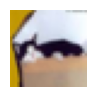

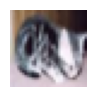

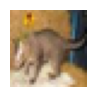

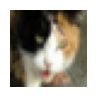

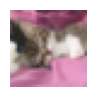

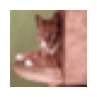

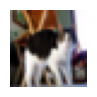

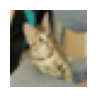

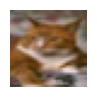

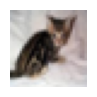

cat_c_defocus_blur <> cat
Image shape = (3072,)


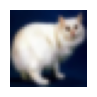

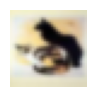

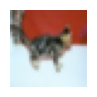

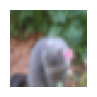

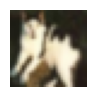

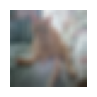

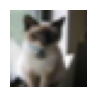

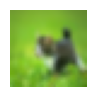

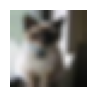

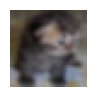

In [144]:
def show_most_confused(source_intent, target_intent, estimator, class_names):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    closest_to_second = np.argsort([sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()])[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    
    # Verifica la forma de la primera imagen y guárdala para impresión
    if len(dataset_indices) > 0:
        first_image = fully_dataset[int(dataset_indices[0])]
        print(f"Image shape = {first_image.shape}")

    for di in dataset_indices:
        image = fully_dataset[int(di)]
        
        # Convertir el vector 1D a una imagen 3D para que matplotlib pueda graficarlo
        if image.shape == (3072,):  # Asegurarse que la forma sea 3072
            image = image.reshape((32, 32, 3))  # Cambiar según el formato correcto de la imagen
        
        plt.figure(figsize=(1, 1))
        plt.imshow(image, cmap=plt.get_cmap('gray'))
        plt.axis('off')  # Para ocultar los ejes
        plt.show()

first_pair = pairs[0]
show_most_confused(first_pair[0], first_pair[1], estimator, class_names)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names)



cat <> cat_c_defocus_blur
(10,)
	Nombre del archivo: domestic_cat_s_000565.png, Clase: cat, Similitud: 10000.0000


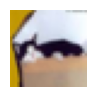

	Nombre del archivo: tabby_s_000720.png, Clase: cat, Similitud: 10000.0000


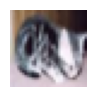

	Nombre del archivo: tabby_cat_s_001985.png, Clase: cat, Similitud: 10000.0000


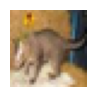

	Nombre del archivo: felis_catus_s_000972.png, Clase: cat, Similitud: 10000.0000


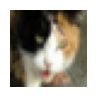

	Nombre del archivo: tabby_s_001111.png, Clase: cat, Similitud: 10000.0000


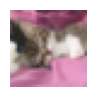

	Nombre del archivo: house_cat_s_001310.png, Clase: cat, Similitud: 10000.0000


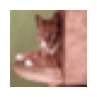

	Nombre del archivo: tabby_cat_s_000388.png, Clase: cat, Similitud: 10000.0000


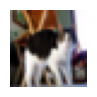

	Nombre del archivo: house_cat_s_000333.png, Clase: cat, Similitud: 10000.0000


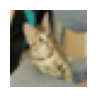

	Nombre del archivo: tabby_cat_s_001455.png, Clase: cat, Similitud: 10000.0000


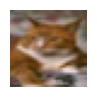

	Nombre del archivo: felis_domesticus_s_000426.png, Clase: cat, Similitud: 10000.0000


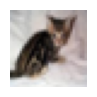

cat_c_defocus_blur <> cat
(10,)
	Nombre del archivo: 10565.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


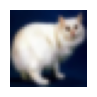

	Nombre del archivo: 29862.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


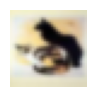

	Nombre del archivo: 02684.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


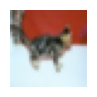

	Nombre del archivo: 10418.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


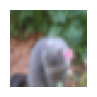

	Nombre del archivo: 17378.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


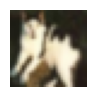

	Nombre del archivo: 42422.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


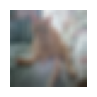

	Nombre del archivo: 06680.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


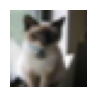

	Nombre del archivo: 35620.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


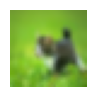

	Nombre del archivo: 46680.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


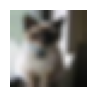

	Nombre del archivo: 26722.png, Clase: cat_c_defocus_blur, Similitud: 6000.0000


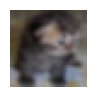

In [145]:
# Muestras mas similares utilizando la matriz W

def show_most_confused(source_intent, target_intent, estimator, class_names, filenames_dict):  
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")  
    
    # Obtener las probabilidades de la clase objetivo  
    probabilities = [sample.sample_probability_norm[target_intent] for sample in estimator.similarity_arrays[source_intent].values()]  
    
    # Ordenar en orden descendente (De mas similar a menos similar)  
    closest_to_second = np.argsort(probabilities)[::-1][:10]  
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]  
    print(dataset_indices.shape)  

    # Verificar que los índices estén dentro de los límites del dataset  
    valid_indices = [int(di) for di in dataset_indices if int(di) < len(filenames_dict)]  
    
    for di in valid_indices:  
        try:  
            # filename ahora es la ruta completa
            filename_route = filenames_dict[int(di)]  # Directorio en donde estan las imagenes 
            filename = Path(filename_route).name  # Extraer solo el nombre del archivo sin su ruta
            value = probabilities[closest_to_second[np.where(dataset_indices == di)[0][0]]]  
            print(f"\tNombre del archivo: {filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")  
            
            # Cargar y mostrar la imagen  
            img = plt.imread(filename_route)  # filename_route es la ruta completa donde estan las imagenes 
            plt.figure(figsize=(1, 1))  
            plt.imshow(img)  
            plt.axis('off')  
            plt.show()  
            
        except IndexError:  
            print(f"\tIndexError: Index {int(di)} is out of bounds for the dataset.")  
        except FileNotFoundError:  
            print(f"\tFileNotFoundError: No such file: {filename_route}")  

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]  
pairs = [(0, 1)]  

first_pair = pairs[0]  
show_most_confused(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)  
show_most_confused(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

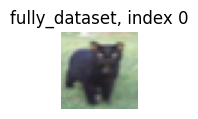

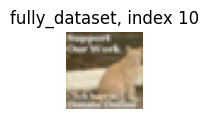

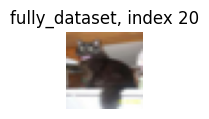

In [146]:
# Verificar algunos índices y sus imágenes correspondientes
indices_a_verificar = [0, 10, 20]  # Ejemplo de algunos índices

for idx in indices_a_verificar:
    
    image_fully_dataset = fully_dataset[idx].reshape((32, 32, 3))  # Reorganizar si es necesario

    # Mostrar imagen de fully_dataset
    plt.figure(figsize=(1, 1))
    plt.imshow(image_fully_dataset)
    plt.axis('off')
    plt.title(f'fully_dataset, index {idx}')
    plt.show()


Pruebas César

*   Extraer 10 muestras (archivos de imágenes) en orden 1
*   Extraer 10 muestras (archivos de imágenes) en orden -1
*   Entrenar un modelo con el dataset CIFAR10_2clases
*   Realizar predicción sobre las 20 imágenes (Cat/Cat_c)
*   Entrenar un modelo con el dataset CIFAR10
*   Realizar predicción sobre las 20 imágenes (airplane, automobile, bird,  cat, deer, dog, frog, horse, ship, truck)
*   Probar con el dataset Santiago


